# Evaluating A Churn Prediction Model with CAP Curve

The aim of this notebook is to provide further explanations on how to use a Cumulative Accuracy Profile (CAP) curve to evaluate a churn prediction model on its ability to allocate resources optimally.

## Example Problem Statement

If your business has 500 discount vouchers to give out to a population of 1409 customers and there are 374 customers who actually wishes to churn, how do you select 500 out of these 1409 customers to give the vouchers to so as to maximize the number of churn cases present within these selected 500 customers?

NOTE: The numbers 1409 and 374 are based on the test set generated later in this notebook. Use the same random state to get the same results!

## Table of Contents

1. [Import Packages](#1)
2. [Import Data](#2)
3. [Exploratory Data Analysis](#3)
4. [Preprocess Data](#4)
5. [Trivial Feature Engineering](#5)
6. [Train Model](#6)
7. [Evaluation](#7)
8. [Further Evaluation with CAP](#8)
9. [Conclusion](#9)
10. [References](#10)

## Import Packages <a class="anchor" id="1"></a>

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, auc
%matplotlib inline

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


Using TensorFlow backend.


In [2]:
df = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis <a class="anchor" id="3"></a>

### Observations
- There are no null values
- *gender*: There seems to be an equal distribution of males and females with respect to churn intention
- *SeniorCitizen*: There are much fewer senior citizens and there is a larger proportion of senior citizens churning
- *Partner*: There seems to be an equal distribution of people having and not having partners, there is also a larger proportion of people with partners churning
- *Dependents*: There are much fewer people with dependents, there is a larger proportion of people with no dependents churning
- *PhoneService*: There are many more people with a phone service
- *MultipleLines*: The numbers of people who have and do not have multiple lines are similar
- *InternetService*: There are many more people who has an internet service and there is a large proportion of people with fiber optic internet service who intend to churn
- *OnlineSecurity*: For those with an internet service, there are more people with no online security and a large proportion of the same group of people has churned.
- *OnlineBackup*: For those with an internet service, there are more people with no online backup and a large proportion of the same group of people has churned
- *DeviceProtection*: For those with an internet service, there are more people with no device protection and a large proportion of the same group of people has churned
- *TechSupport*: For those with an internet service, there are more people with no tech support and a large proportion of the same group of people has churned
- *StreamingTV*: There seems to be an equal distribution of people who did and did not have streaming tv with respect to churn intention
- *StreamingMovies*: There seems to be an equal distribution of people who did and did not have streaming movies with respect to churn intention
- *Contract*: There are many more people who are on a month-to-month contract and a large proportion of this group of people has churned
- *PaperlessBilling*: The number of people with paperless billing is quite similar to that with
- *PaymentMethod*: There are more people adopting electronic check as a payment method and a large proportion of them has churned
- *Churn*: The number of churn cases is significantly fewer than that of non-churn ones
- *tenure*: The distribution of tenure periods seems to be quite even except that for two peaks at the extreme ends
- *MonthlyCharges*: Highest peak appears at the lower spectrum of values
- *TotalCharges*: Distribution of values is right skewed

In [3]:
df["MonthlyCharges"] = df["MonthlyCharges"].apply(float)
df["TotalCharges"] = df["TotalCharges"].replace(' ',None) # to ensure that TotalCharges can be successfully converted to a float column
df["TotalCharges"] = df["TotalCharges"].apply(float)
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

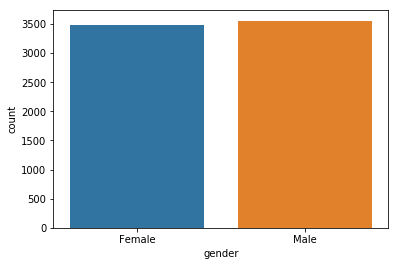

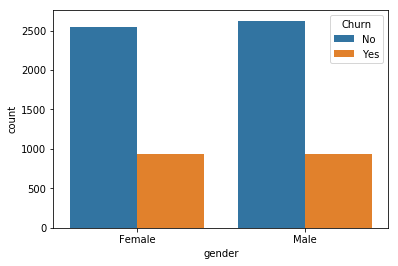

In [4]:
plt.figure()
sns.countplot(x="gender", data=df)
plt.figure()
sns.countplot(x="gender", hue="Churn", data=df)

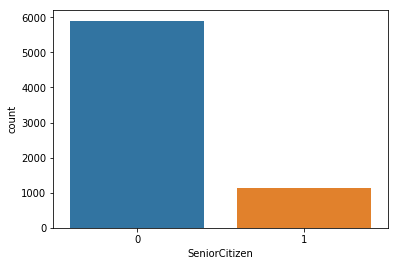

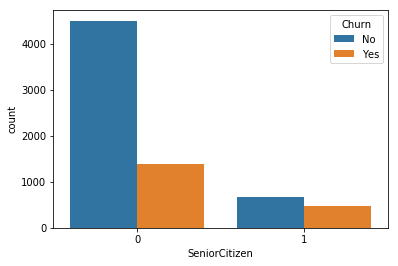

In [5]:
plt.figure()
sns.countplot(x="SeniorCitizen", data=df)
plt.figure()
sns.countplot(x="SeniorCitizen", hue="Churn", data=df)

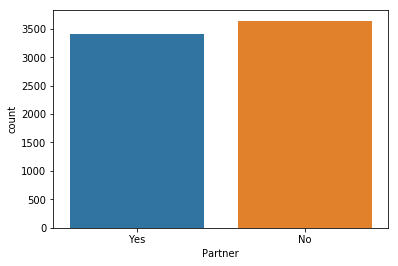

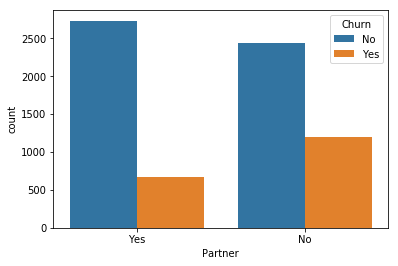

In [6]:
plt.figure()
sns.countplot(x="Partner", data=df)
plt.figure()
sns.countplot(x="Partner", hue="Churn", data=df)

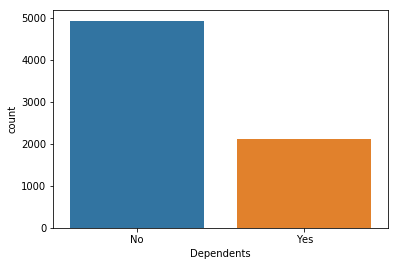

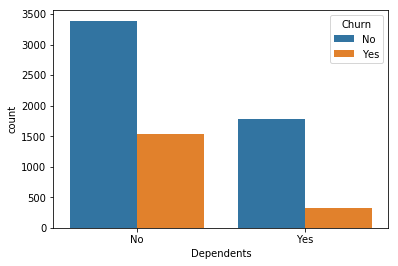

In [7]:
plt.figure()
sns.countplot(x="Dependents", data=df)
plt.figure()
sns.countplot(x="Dependents", hue="Churn", data=df)

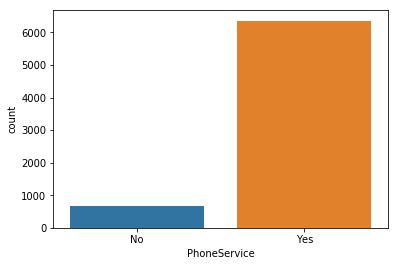

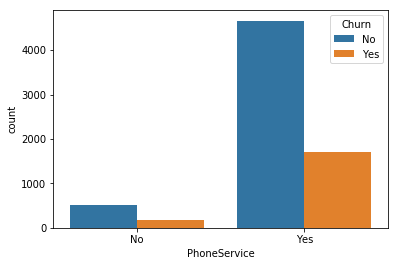

In [8]:
plt.figure()
sns.countplot(x="PhoneService", data=df)
plt.figure()
sns.countplot(x="PhoneService", hue="Churn", data=df)

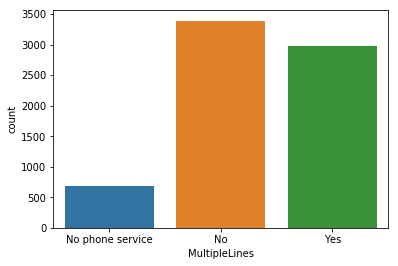

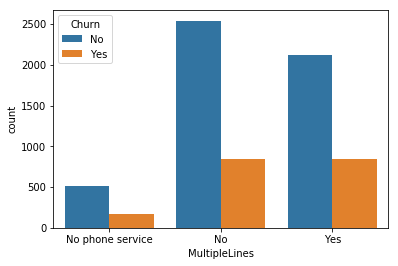

In [9]:
plt.figure()
sns.countplot(x="MultipleLines", data=df)
plt.figure()
sns.countplot(x="MultipleLines", hue="Churn", data=df)

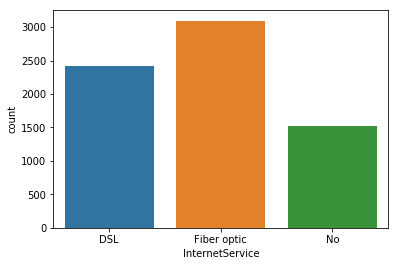

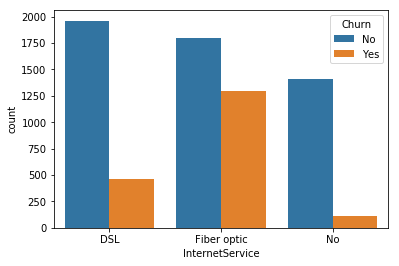

In [10]:
plt.figure()
sns.countplot(x="InternetService", data=df)
plt.figure()
sns.countplot(x="InternetService", hue="Churn", data=df)

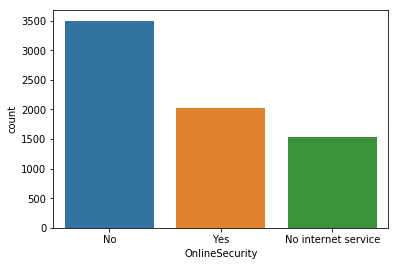

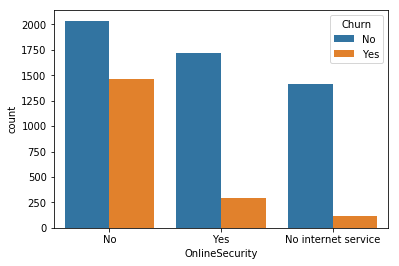

In [11]:
plt.figure()
sns.countplot(x="OnlineSecurity", data=df)
plt.figure()
sns.countplot(x="OnlineSecurity", hue="Churn", data=df)

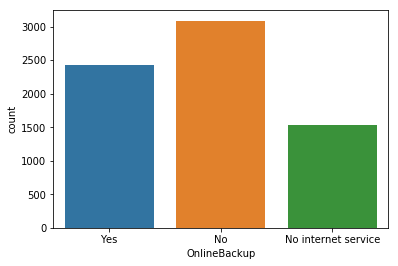

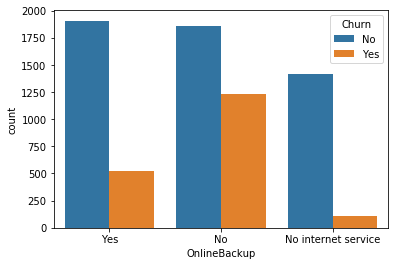

In [12]:
plt.figure()
sns.countplot(x="OnlineBackup", data=df)
plt.figure()
sns.countplot(x="OnlineBackup", hue="Churn", data=df)

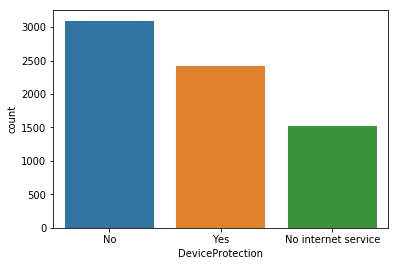

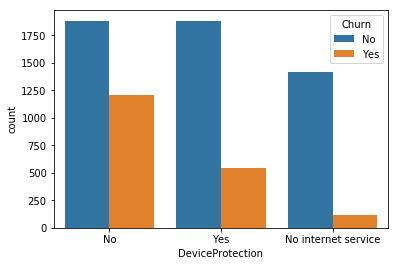

In [13]:
plt.figure()
sns.countplot(x="DeviceProtection", data=df)
plt.figure()
sns.countplot(x="DeviceProtection", hue="Churn", data=df)

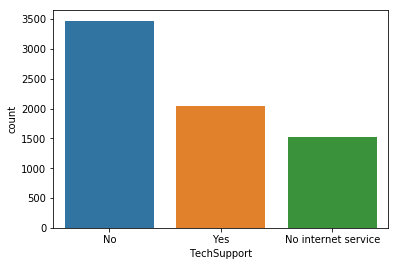

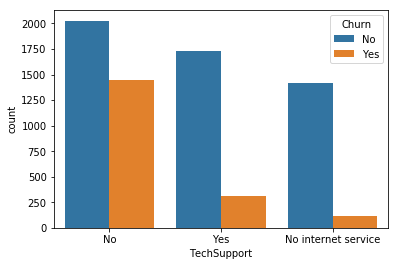

In [14]:
plt.figure()
sns.countplot(x="TechSupport", data=df)
plt.figure()
sns.countplot(x="TechSupport", hue="Churn", data=df)

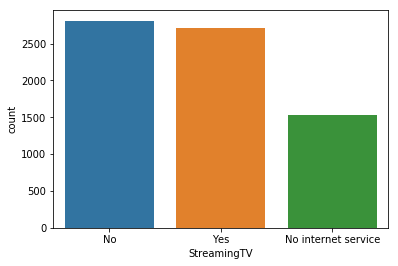

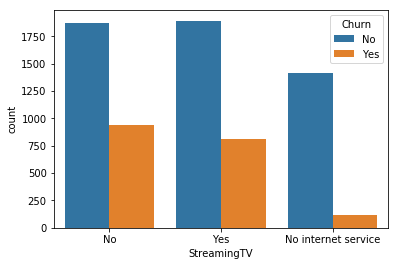

In [15]:
plt.figure()
sns.countplot(x="StreamingTV", data=df)
plt.figure()
sns.countplot(x="StreamingTV", hue="Churn", data=df)

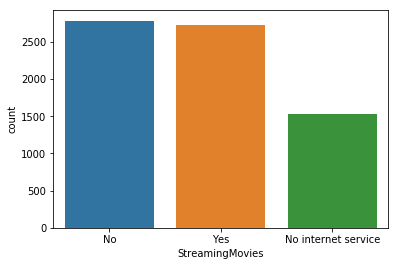

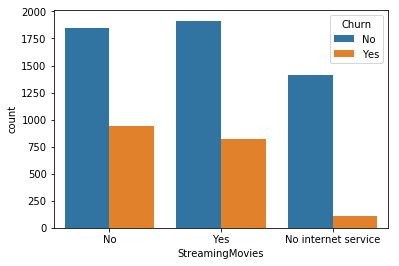

In [16]:
plt.figure()
sns.countplot(x="StreamingMovies", data=df)
plt.figure()
sns.countplot(x="StreamingMovies", hue="Churn", data=df)

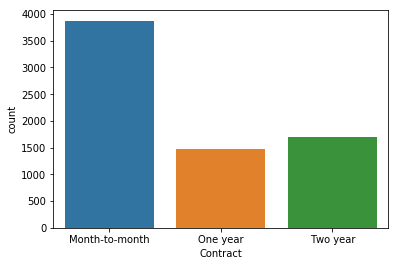

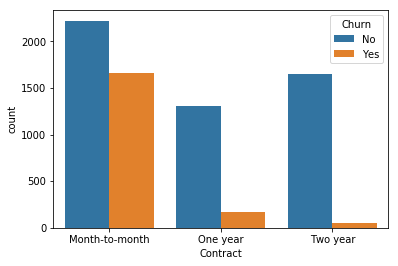

In [17]:
plt.figure()
sns.countplot(x="Contract", data=df)
plt.figure()
sns.countplot(x="Contract", hue="Churn", data=df)

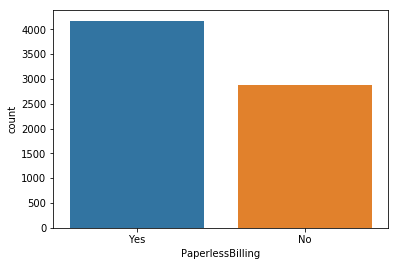

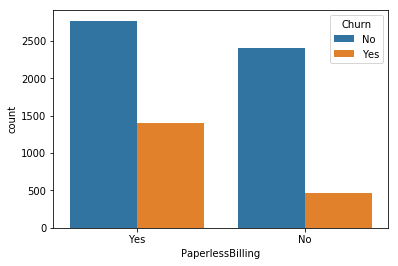

In [18]:
plt.figure()
sns.countplot(x="PaperlessBilling", data=df)
plt.figure()
sns.countplot(x="PaperlessBilling", hue="Churn", data=df)

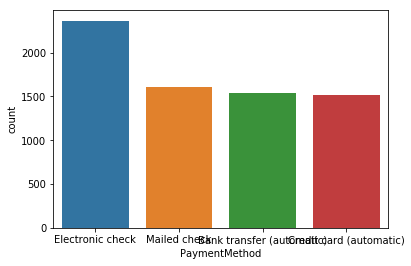

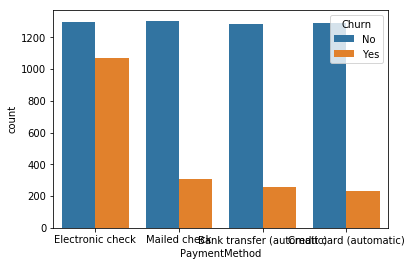

In [19]:
plt.figure()
sns.countplot(x="PaymentMethod", data=df)
plt.figure()
sns.countplot(x="PaymentMethod", hue="Churn", data=df)

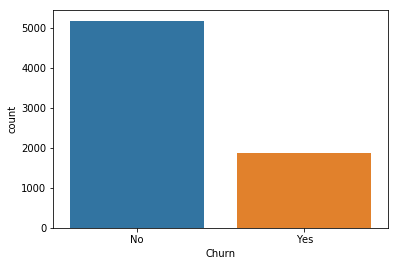

In [20]:
sns.countplot(x="Churn", data=df)

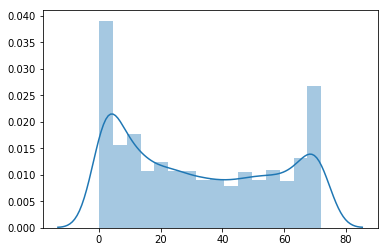

In [21]:
sns.distplot(df["tenure"].tolist())

In [22]:
df["tenure"].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

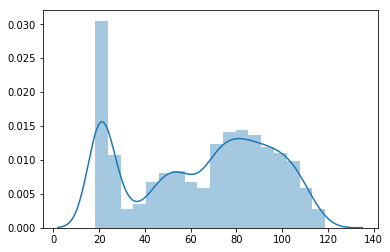

In [23]:
sns.distplot(df["MonthlyCharges"].tolist())

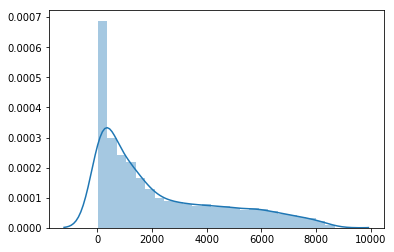

In [24]:
sns.distplot(df["TotalCharges"].tolist())

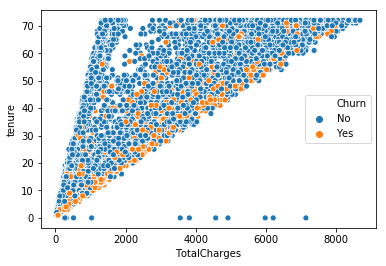

In [25]:
sns.scatterplot(x="TotalCharges", y="tenure", hue="Churn",
                     data=df)

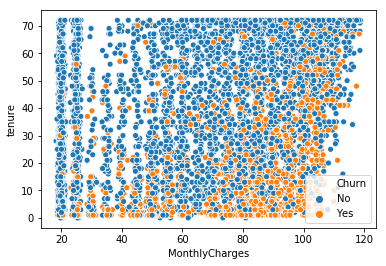

In [26]:
sns.scatterplot(x="MonthlyCharges", y="tenure", hue="Churn",
                     data=df)

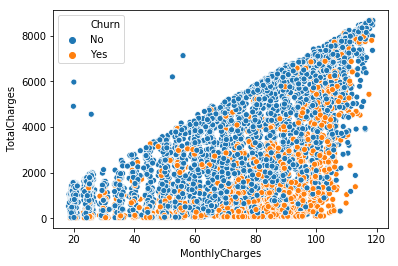

In [27]:
sns.scatterplot(x="MonthlyCharges", y="TotalCharges", hue="Churn",
                     data=df)

## Preprocess Data <a class="anchor" id="4"></a>



### Columns

- customerID
    - Insignificant to the classification task
- gender
    - Unique values are male and female, we can choose to let 1 and 0 represent male and female respectively
- SeniorCitizen
    - Unique values are 1 and 0, with 1 meaning that the customer is a senior citizen, so no preprocessing is needed
- Partner
    - Unique values are yes and no, we can choose to let 1 and 0 represent yes and no respectively
- Dependents
    - Unique values are yes and no, we can choose to let 1 and 0 represent yes and no respectively
- tenure
    - Binning all the values, 5 buckets, multiples of 12
- PhoneService
    - Unique values are yes and no, we can choose to let 1 and 0 represent yes and no respectively
- MultipleLines
    - Unique values are yes, no and no phone service, we can choose to let 0, 1 and 2 represent no phone service, no and yes respectively
- InternetService
    - Unique values are dsl, fiber optic and no, we can choose to let 0, 1 and 2 represent no, dsl and fiber optic respectively. Also, fiber optic's speed is much faster than dsl
- OnlineSecurity
    - Unique values are yes, no and no internet service, we can choose to let 0, 1 and 2 represent no internet service, no and yes
- OnlineBackup
    - Unique values are yes, no and no internet service, we can choose to let 0, 1 and 2 represent no internet service, no and yes
- DeviceProtection
    - Unique values are yes, no and no internet service, we can choose to let 0, 1 and 2 represent no internet service, no and yes
- TechSupport
    - Unique values are yes, no and no internet service, we can choose to let 0, 1 and 2 represent no internet service, no and yes
- StreamingTV
    - Unique values are yes, no and no internet service, we can choose to let 0, 1 and 2 represent no internet service, no and yes
- StreamingMovies
    - Unique values are yes, no and no internet service, we can choose to let 0, 1 and 2 represent no internet service, no and yes
- Contract
    - Unique values are month-to-month, one year and two year, we can choose to let 0, 1 and 2 represent month-to-month, one year and two year
- PaperlessBilling
    - Unique values are yes and no, but I would choose to drop this column as I believe that it has no causation effect on whether a customer churns
- PaymentMethod
    - Unique values are Credit card (automatic), Bank transfer (automatic), Mailed check, Electronic check and they will represented by values 1, 1, 0 and 0 respectively. Automatic methods would create more convenience for the customers
- MonthlyCharges
    - Standardization would be applied
- Total Charges
    - Standardization would be applied
- Churn
    - Unique values are yes and no, we can choose to let 0 and 1 represent non-churn and churn cases respectively

### Ordinal Encoding

In [28]:
label_encoding = {
                    "Partner": {
                            "Yes": 1,
                            "No": 0
                        },
                        "Dependents": {
                            "Yes": 1,
                            "No": 0
                        },
                        "PhoneService": {
                            "Yes": 1,
                            "No": 0
                        },
                        "MultipleLines": {
                            "Yes": 2,
                            "No": 1,
                            "No phone service": 0
                        },
                        "InternetService": {
                            "Fiber optic": 2,
                            "DSL": 1,
                            "No": 0
                        },
                        "OnlineSecurity": {
                            "Yes": 2,
                            "No": 1,
                            "No internet service": 0
                        },
                        "OnlineBackup": {
                            "Yes": 2,
                            "No": 1,
                            "No internet service": 0
                        },
                        "DeviceProtection": {
                            "Yes": 2,
                            "No": 1,
                            "No internet service": 0
                        },
                        "TechSupport": {
                            "Yes": 2,
                            "No": 1,
                            "No internet service": 0
                        },
                        "StreamingTV": {
                            "Yes": 2,
                            "No": 1,
                            "No internet service": 0
                        },
                        "StreamingMovies": {
                            "Yes": 2,
                            "No": 1,
                            "No internet service": 0
                        },
                        "Contract": {
                            "Two year": 2,
                            "One year": 1,
                            "Month-to-month": 0
                        },
                        "PaymentMethod": {
                            "Credit card (automatic)": 1,
                            "Bank transfer (automatic)": 1,
                            "Mailed check": 0,
                            "Electronic check": 0
                        },
                        "Churn": {
                            "Yes": 1,
                            "No": 0
                        },
                        "gender": {
                            "Male": 1,
                            "Female": 0
                        }
                    }

for column, val_mapping in label_encoding.items():
    df[column] = df[column].apply(lambda i: val_mapping[i])
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,1,1,...,1,1,1,1,0,Yes,0,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,1,1,2,...,2,1,1,1,1,No,0,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,1,1,2,...,1,1,1,1,0,Yes,0,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,2,...,2,2,1,1,1,No,1,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,1,2,1,...,1,1,1,1,0,Yes,0,70.70,151.65,1


### Standardizing

In [29]:
std_cols = ["MonthlyCharges", "TotalCharges"]
for column in std_cols:
    df[column] = df[column].apply(lambda i: (i-df[column].mean()) / df[column].std())
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,1,1,...,1,1,1,1,0,Yes,0,-1.160241,-0.994609,0
1,5575-GNVDE,1,0,0,0,34,1,1,1,2,...,2,1,1,1,1,No,0,-0.259611,-0.174493,0
2,3668-QPYBK,1,0,0,0,2,1,1,1,2,...,1,1,1,1,0,Yes,0,-0.362635,-0.960078,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,2,...,2,2,1,1,1,No,1,-0.746482,-0.195992,0
4,9237-HQITU,0,0,0,0,2,1,1,2,1,...,1,1,1,1,0,Yes,0,0.197351,-0.940894,1


### Binning

In [30]:
new_tenure = []
for i in df["tenure"]:
    if i <= 12:
        new_tenure.append(0)
    elif i <= 24:
        new_tenure.append(1)
    elif i <= 36:
        new_tenure.append(2)
    elif i <= 48:
        new_tenure.append(3)
    elif i <= 60:
        new_tenure.append(4)
    else:
        new_tenure.append(5)
df["tenure"] = new_tenure
df["tenure"].head()

0    0
1    2
2    0
3    3
4    0
Name: tenure, dtype: int64

## Trivial Feature Engineering <a class="anchor" id="5"></a>

- Responsibility_Score: Average of partner, dependents and senior citizen to determine a score which determines the amount of life-related responsibility one has.
- Phone_Reliance: Average of PhoneService and MultipleLines to determine a score which determines the extent of reliance one has on phone service.
- Support: Average of InternetService, StreamingTV and StreamingMovies to determine a score which determines the amount of support services one has.
- Duration: Average of tenure and contract to determine an aggregation score of time-related factors

In [31]:
df["Responsibility_Score"] = (df["Partner"] + df["Dependents"] + df["SeniorCitizen"]) / 3
df["Phone_Reliance"] = (df["PhoneService"] + df["MultipleLines"]) / 2
df["Support"] = (df["OnlineSecurity"] + df["OnlineBackup"] + df["DeviceProtection"] + df["TechSupport"]) / 4
df["Online_Services"] = (df["InternetService"] + df["StreamingTV"] + df["StreamingMovies"]) / 3
df["Duration"] = (df["tenure"] + df["Contract"]) / 2

### Drop Columns

In [32]:
drop_cols = ["PaperlessBilling","Partner", "Dependents", "SeniorCitizen", "PhoneService", "MultipleLines",
            "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
            "InternetService", "StreamingTV", "StreamingMovies",
            "tenure", "Contract"]
df = df.drop(drop_cols, axis=1)
df.head()

,customerID,gender,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Responsibility_Score,Phone_Reliance,Support,Online_Services,Duration
0,7590-VHVEG,0,0,-1.160241,-0.994609,0,0.333333,0.0,1.25,1.000000,0.0
1,5575-GNVDE,1,0,-0.259611,-0.174493,0,0.000000,1.0,1.50,1.000000,1.5
2,3668-QPYBK,1,0,-0.362635,-0.960078,1,0.000000,1.0,1.50,1.000000,0.0
3,7795-CFOCW,1,1,-0.746482,-0.195992,0,0.000000,0.0,1.75,1.000000,2.0
4,9237-HQITU,0,0,0.197351,-0.940894,1,0.000000,1.0,1.00,1.333333,0.0


## Train Model <a class="anchor" id="6"></a>

In [33]:
# Train Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=100, stratify=df["Churn"].tolist())
train_X = train_df.drop(["customerID", "Churn"], axis=1).values
train_Y = train_df["Churn"].tolist()
test_X = test_df.drop(["customerID", "Churn"], axis=1).values
test_Y = test_df["Churn"].tolist()

# Oversample using SMOTE
sampler = SMOTE(random_state=100, k_neighbors=7)
train_X, train_Y = sampler.fit_resample(train_X, train_Y)

# Train Model
# rf = RandomForestClassifier()
# model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=100, n_jobs = -1)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_X, train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

## Evaluation <a class="anchor" id="7"></a>

### Typical Metrics

In [34]:
predictions = model.predict(test_X)
prediction_proba = model.predict_proba(test_X)

In [35]:
report_ = []
lines = classification_report(test_Y, predictions).split('\n')
for l in lines[2:-4]:
    row_ = l.split()
    if len(row_) != 0:
        row = {}
        row['precision'] = float(row_[-4])
        row['recall'] = float(row_[-3])
        row['f1_score'] = float(row_[-2])
        row['support'] = float(row_[-1])
        row['class'] = {1: "Churn", 0: "No Churn"}[int(row_[0])]
        report_.append(row)
dataframe = pd.DataFrame.from_dict(report_)
dataframe.head()

,precision,recall,f1_score,support,class
0,0.86,0.69,0.77,1035.0,No Churn
1,0.45,0.69,0.54,374.0,Churn


In [36]:
print("ROC AUC Score: {}\n\n".format(roc_auc_score(test_Y, prediction_proba[:, 1])))
print("Accuracy Score: {}\n\n".format(accuracy_score(test_Y, predictions)))

confusion_mat = confusion_matrix(test_Y, predictions, labels=[0, 1])
_row = confusion_mat.sum(axis=0)
_col = [np.nan] + list(confusion_mat.sum(axis=1)) + [sum(_row)]
con_df = pd.DataFrame({})
con_df["Predicted"] = ["Actual"] + ["No Churn", "Churn"] + ["All"]
for label, idx in {"No Churn": 0, "Churn": 1}.items():
    temp = [np.nan] + list(confusion_mat[:, idx]) + [_row[idx]]
    con_df[label] = temp

con_df["All"] = _col
print("Confusion Matrix\n")
con_df

ROC AUC Score: 0.7482755948229094


Accuracy Score: 0.6905606813342796


Confusion Matrix



,Predicted,No Churn,Churn,All
0,Actual,NaN,NaN,NaN
1,No Churn,714.0,321.0,1035.0
2,Churn,115.0,259.0,374.0
3,All,829.0,580.0,1409.0


## Further Evaluation with CAP <a class="anchor" id="8"></a>

### Obtain CAP Curve and Accuracy Rate

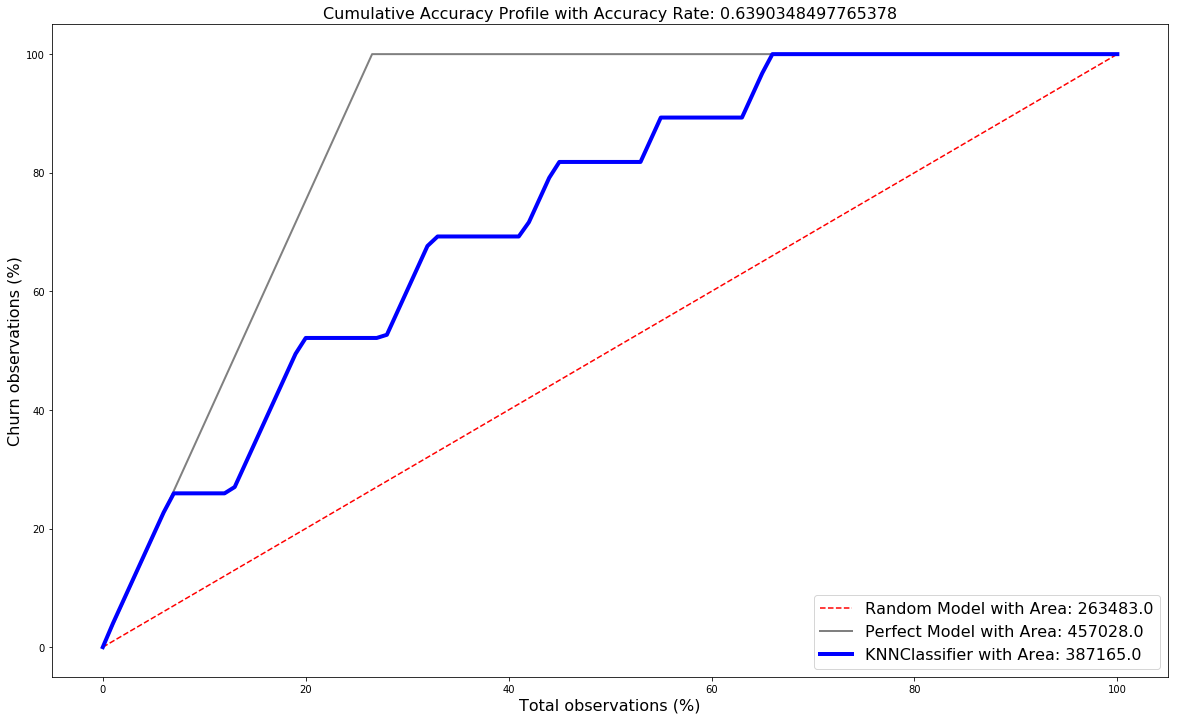

In [37]:
sorted_proba = [y for _, y in sorted(zip(prediction_proba[:, -1], test_Y), reverse = True)] # sorting with predicted probabilities of churning as key
y_cum = np.append([0], np.cumsum(sorted_proba)) # cumulative sum of true labels sorted previously
total_points = len(test_Y) # total number of plot points
class_1_count = np.sum(test_Y) # Number of true churn samples
x_points = np.arange(0, total_points + 1) # generate data points for x axis
random_model_area = auc([0, total_points], [0, class_1_count]) # area under random model
perfect_model_area = auc([0, class_1_count, total_points], [0, class_1_count, class_1_count]) # area under perfect model
trained_model_area = auc(x_points, y_cum) # area under trained model
perfect_vs_random = perfect_model_area - random_model_area # area between perfect and random model
trained_vs_random = trained_model_area - random_model_area # area between trained and random model
accuracy_rate = trained_vs_random / perfect_vs_random # accuracy rate

plt.figure(figsize = (20, 12))
plt.plot([0, 100], [0, 100], c = 'r', linestyle = '--', label = 'Random Model with Area: {}'.format(random_model_area))
plt.plot([0, (class_1_count/total_points)*100, 100], 
        [0, 100, 100], 
        c = 'grey', 
        linewidth = 2, 
        label = 'Perfect Model with Area: {}'.format(perfect_model_area))
cum = (np.cumsum(sorted_proba)/class_1_count)*100
cum = [cum[i] for i in range(0, len(cum), len(cum)//100)]
y_values = np.append([0], cum[-100:])
x_values = np.arange(0, 101)
plt.plot(x_values, 
        y_values, 
        c = 'b', 
        label = "KNNClassifier with Area: {}".format(trained_model_area), 
        linewidth = 4)
plt.xlabel('Total observations (%)', fontsize = 16)
plt.ylabel('Churn observations (%)', fontsize = 16)
plt.title('Cumulative Accuracy Profile with Accuracy Rate: {}'.format(accuracy_rate), fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)


In [38]:
print("Our Model Has Selected 500 Customers Out of {} Customers and Managed to Identify {} Churn Cases Out of a Total of {} Churn Cases"\
     .format(len(sorted_proba), sum(sorted_proba[:500]), sum(sorted_proba)))

Our Model Has Selected 500 Customers Out of 1409 Customers and Managed to Identify 259 Churn Cases Out of a Total of 374 Churn Cases


## Conclusion <a class="anchor" id="9"></a>

The CAP curve and related metrics are useful in evaluating a churn prediction model's capability in optimal allocation of resources. The model used in this notebook has achieved decent performance by first picking 500 customers to give vouchers to as a preventive measure of churn and then successfully identifying 259 churn cases.

Better models would be able to identify many more churn cases within 500 selected customers, hence enhancing the effectiveness of the preventive measure of churn.

Models' performances in reducing costs and enhancing effectiveness of preventive measures of churn can be assessed to be exceptional based on the number of churn cases identified within a fixed number of customers or the number of customers required to identify all the churn cases.

## References <a class="anchor" id="10"></a>

- https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction
- https://towardsdatascience.com/machine-learning-classifier-evaluation-using-roc-and-cap-curves-7db60fe6b716